# 1. Download data from Don’tGetKicked competition.

In [1]:
!pip install lightgbm catboost xgboost -q

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna
from collections import Counter
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, FunctionTransformer, OrdinalEncoder
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, average_precision_score, classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import RandomizedSearchCV

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

pd.set_option('display.max_columns', None)

Field Name --- Definition

RefID --- Unique (sequential) number assigned to vehicles
IsBadBuy (target) --- Identifies if the kicked vehicle was an avoidable - purchase
PurchDate --- The Date the vehicle was Purchased at Auction
Auction --- Auction provider at which the vehicle was purchased
VehYear --- The manufacturer's year of the vehicle
VehicleAge --- The Years elapsed since the manufacturer's year
Make --- Vehicle Manufacturer
Model --- Vehicle Model
Trim --- Vehicle Trim Level
SubModel --- Vehicle Submodel
Color --- Vehicle Color
Transmission --- Vehicles transmission type (Automatic, Manual)
WheelTypeID --- The type id of the vehicle wheel
WheelType --- The vehicle wheel type description (Alloy, Covers)
VehOdo --- The vehicles odometer reading
Nationality --- The Manufacturer's country
Size --- The size category of the vehicle (Compact, SUV, etc.)
TopThreeAmericanName --- Identifies if the manufacturer is one of the top three American manufacturers
MMRAcquisitionAuctionAveragePrice --- Acquisition price for this vehicle in average condition at time of purchase
MMRAcquisitionAuctionCleanPrice --- Acquisition price for this vehicle in the above Average condition at time of purchase
MMRAcquisitionRetailAveragePrice --- Acquisition price for this vehicle in the retail market in average condition at time of purchase
MMRAcquisitonRetailCleanPrice --- Acquisition price for this vehicle in the retail market in above average condition at time of purchase
MMRCurrentAuctionAveragePrice --- Acquisition price for this vehicle in average condition as of current day
MMRCurrentAuctionCleanPrice --- Acquisition price for this vehicle in the above condition as of current day
MMRCurrentRetailAveragePrice --- Acquisition price for this vehicle in the retail market in average condition as of current day
MMRCurrentRetailCleanPrice --- Acquisition price for this vehicle in the retail market in above average condition as of current day
PRIMEUNIT --- Identifies if the vehicle would have a higher demand than a standard purchase
AcquisitionType --- Identifies how the vehicle was aquired (Auction buy, trade in, etc)
AUCGUART --- The level guarntee provided by auction for the vehicle (Green light - Guaranteed/arbitratable, Yellow Light - caution/issue, red light - sold as is)
KickDate --- Date the vehicle was kicked back to the auction
BYRNO --- Unique number assigned to the buyer that purchased the vehicle
VNZIP --- Zipcode where the car was purchased
VNST --- State where the the car was purchased
VehBCost --- Acquisition cost paid for the vehicle at time of purchase
IsOnlineSale --- Identifies if the vehicle was originally purchased online
WarrantyCost --- Warranty price (term=36month and millage=36K)

In [3]:
df = pd.read_csv('ml4_training.csv')
df['PurchDate'] = pd.to_datetime(df['PurchDate'], errors='coerce')
df['PurchDate'].notnull().all()

True

In [4]:
df.sort_values(by='PurchDate',ascending=True,inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72983 entries, 32367 to 70421
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   RefId                              72983 non-null  int64         
 1   IsBadBuy                           72983 non-null  int64         
 2   PurchDate                          72983 non-null  datetime64[ns]
 3   Auction                            72983 non-null  object        
 4   VehYear                            72983 non-null  int64         
 5   VehicleAge                         72983 non-null  int64         
 6   Make                               72983 non-null  object        
 7   Model                              72983 non-null  object        
 8   Trim                               70623 non-null  object        
 9   SubModel                           72975 non-null  object        
 10  Color                              

In [6]:
df.head()

,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,WheelTypeID,WheelType,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
32367,32389,0,2009-01-05,MANHEIM,2007,2,CHRYSLER,PACIFICA FWD 3.8L V6,Bas,4D SPORT,BLUE,AUTO,2.0,Covers,78541,AMERICAN,CROSSOVER,CHRYSLER,7261.0,8857.0,8342.0,10066.0,8709.0,10331.0,9906.0,11657.0,NaN,NaN,3453,80022,CO,6770.0,0,1389
32384,32406,0,2009-01-05,MANHEIM,2005,4,FORD,FREESTAR FWD V6 3.9L,SES,4D PASSENGER 3.9L SES,SILVER,AUTO,1.0,Alloy,37676,AMERICAN,VAN,FORD,4409.0,5734.0,5262.0,6693.0,4908.0,5971.0,5801.0,6949.0,NaN,NaN,22916,80022,CO,6160.0,0,941
32385,32407,0,2009-01-05,MANHEIM,2004,5,DODGE,STRATUS 4C 2.4L I4 M,SE,4D SEDAN SE,SILVER,AUTO,2.0,Covers,71680,AMERICAN,MEDIUM,CHRYSLER,3098.0,4061.0,3846.0,4886.0,3397.0,4272.0,4169.0,5114.0,NaN,NaN,3453,80022,CO,4250.0,0,1155
32386,32408,0,2009-01-05,MANHEIM,2006,3,CHEVROLET,TRAILBLAZER EXT 4WD,LS,4D SUV 4.2L,WHITE,AUTO,1.0,Alloy,69456,AMERICAN,MEDIUM SUV,GM,8530.0,9883.0,9712.0,11174.0,9202.0,10794.0,10438.0,12158.0,NaN,NaN,22916,80022,CO,8180.0,0,1703
32387,32409,0,2009-01-05,MANHEIM,2004,5,FORD,TAURUS 3.0L V6 EFI,SES,4D SEDAN SES DURATEC,GOLD,AUTO,1.0,Alloy,66530,AMERICAN,MEDIUM,FORD,3094.0,4230.0,3842.0,5068.0,3369.0,4492.0,4139.0,5351.0,NaN,NaN,22916,80022,CO,4900.0,0,825


# 2. Design train/validation/test split.

Use the "PurchDate" field for the split, test must be later than validation, same for validation and train: train.PurchDate < valid.PurchDate < test.PurchDate. Use the first 1/3 of dates for the train, the last 1/3 of dates for the test, and the middle 1/3 for the validation set. Don’t use the test dataset until the end!

In [7]:
df['RefId'].duplicated().sum()

0

дублирующиеся id отсутствуют

In [8]:
missing_values_report = pd.DataFrame({
    'Missing Values': df.isnull().sum(),
    'Percentage Missing': df.isnull().mean() * 100
})
print(missing_values_report)

                                   Missing Values  Percentage Missing
RefId                                           0            0.000000
IsBadBuy                                        0            0.000000
PurchDate                                       0            0.000000
Auction                                         0            0.000000
VehYear                                         0            0.000000
VehicleAge                                      0            0.000000
Make                                            0            0.000000
Model                                           0            0.000000
Trim                                         2360            3.233630
SubModel                                        8            0.010961
Color                                           8            0.010961
Transmission                                    9            0.012332
WheelTypeID                                  3169            4.342107
WheelType           

В датасете около 73000 строк присутствует много пропусков, колонки PRIMEUNIT, AUCGUART удалю т.к. в них более 95% пропусков

In [9]:
df.drop(columns=['PRIMEUNIT', 'AUCGUART'], inplace=True)

В WheelType колонках пропусков немного, чтобы не терять данные заполню их

In [10]:
df['WheelType'].value_counts()

WheelType
Alloy      36050
Covers     33004
Special      755
Name: count, dtype: int64

In [11]:
df['WheelTypeID'].value_counts()

WheelTypeID
1.0    36050
2.0    33004
3.0      755
0.0        5
Name: count, dtype: int64

WheelType - 'Unknown', WheelTypeID дублирует предыдущую колонку его удаляю, тк категориальный тип можно интерпретировать

In [12]:
df.drop('WheelTypeID', axis=1, inplace=True)

In [13]:
df['IsBadBuy'].value_counts()

IsBadBuy
0    64007
1     8976
Name: count, dtype: int64

In [14]:
df['Size'].value_counts()

Size
MEDIUM         30785
LARGE           8850
MEDIUM SUV      8090
COMPACT         7205
VAN             5854
LARGE TRUCK     3170
SMALL SUV       2276
SPECIALTY       1915
CROSSOVER       1759
LARGE SUV       1433
SMALL TRUCK      864
SPORTS           777
Name: count, dtype: int64

In [15]:
df['BYRNO'].value_counts()

BYRNO
99761    3943
18880    3588
835      2987
3453     2927
22916    2852
         ... 
99741       1
3582        1
10425       1
1157        1
1086        1
Name: count, Length: 74, dtype: int64

объединение редких признаков

In [16]:
def trim_uniq(column, threshold=0.1, other_name='Other'):
    value_counts = column.value_counts(normalize=True)
    rare_categories = value_counts[value_counts < threshold].index
    trim_column = column.copy()
    trim_column[trim_column.isin(rare_categories)] = other_name
    
    print(f"Было уникальных значений: {column.nunique()}")
    print(f"Стало уникальных значений: {trim_column.nunique()}")
    
    return trim_column

In [17]:
#df['Model'] = trim_uniq(df['Model'], threshold=0.009)

In [18]:
#df['SubModel'] = trim_uniq(df['SubModel'], threshold=0.007)

In [19]:
#df['Trim'] = trim_uniq(df['Trim'], threshold=0.007)

In [20]:
#df['BYRNO'] = df['BYRNO'].astype(str)
#df['BYRNO'] = trim_uniq(df['BYRNO'], threshold=0.025, other_name='Other')

In [21]:
#df['VNST'] = trim_uniq(df['VNST'], threshold=0.004)

Заполнение пропусков

In [22]:
num_cols = ['VehYear', 'VehicleAge', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 'VNZIP1', 'VehBCost', 'IsOnlineSale', 'WarrantyCost']
ohe_cols = ['BYRNO','Auction','Make','Model','Trim','SubModel','Color','Transmission','WheelType','Nationality','Size','TopThreeAmericanName','VNST']

In [23]:
knn_imputer = KNNImputer(n_neighbors=2, weights="uniform")
df[num_cols] = knn_imputer.fit_transform(df[num_cols])

simple_imputer = SimpleImputer(strategy='constant', fill_value='missing')
df[ohe_cols] = simple_imputer.fit_transform(df[ohe_cols])

также удаляется колонка id тк они не несут никакой полезной информации 

In [24]:
X = df.drop(['RefId', 'IsBadBuy'], axis=1) 
y = df['IsBadBuy']

In [25]:
print(X.select_dtypes(include=['int', 'float']).columns.tolist())

['VehYear', 'VehicleAge', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 'VNZIP1', 'VehBCost', 'IsOnlineSale', 'WarrantyCost']


In [26]:
def three_dates_split(X, y, date_column):
    train_end_id = len(X) // 3
    val_end_id = train_end_id * 2
    validation_date = X[date_column].iloc[train_end_id]
    test_date = X[date_column].iloc[val_end_id]
    print('validation', validation_date)
    print('test', test_date)
    train_mask= X[date_column] < validation_date
    valid_mask= (X[date_column] >= validation_date) & (X[date_column] < test_date)
    test_mask= X[date_column] >= test_date
    
    X_train, y_train= X[train_mask].copy(), y[train_mask]
    X_val, y_val= X[valid_mask].copy(), y[valid_mask]
    X_test, y_test= X[test_mask].copy(), y[test_mask]
    return X_train, X_val, X_test, y_train, y_val, y_test

In [27]:
X_train, X_valid, X_test, y_train, y_valid, y_test = three_dates_split(X, y, date_column= 'PurchDate')

validation 2009-09-15 00:00:00
test 2010-05-14 00:00:00


In [28]:
print(f'train max - {X_train["PurchDate"].max()}', f'val min - {X_valid["PurchDate"].min()}', sep="\n")
print(f'val max - {X_valid["PurchDate"].max()}', f'test min - {X_test["PurchDate"].min()}', sep="\n")

train max - 2009-09-14 00:00:00
val min - 2009-09-15 00:00:00
val max - 2010-05-13 00:00:00
test min - 2010-05-14 00:00:00


In [29]:
print(X_train.shape, X_valid.shape, X_test.shape)

(24232, 29) (24414, 29) (24337, 29)


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72983 entries, 32367 to 70421
Data columns (total 31 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   RefId                              72983 non-null  int64         
 1   IsBadBuy                           72983 non-null  int64         
 2   PurchDate                          72983 non-null  datetime64[ns]
 3   Auction                            72983 non-null  object        
 4   VehYear                            72983 non-null  float64       
 5   VehicleAge                         72983 non-null  float64       
 6   Make                               72983 non-null  object        
 7   Model                              72983 non-null  object        
 8   Trim                               72983 non-null  object        
 9   SubModel                           72983 non-null  object        
 10  Color                              

# Encode

Use LabelEncoder or OneHotEncoder from sklearn to preprocess categorical variables. Be careful with data leakage (fit Encoder to training and apply to validation & test). Consider another coding approach if you encounter new categorical values in validation & test (not seen in training)

In [31]:
np.isinf(df[num_cols]).any()

VehYear                              False
VehicleAge                           False
VehOdo                               False
MMRAcquisitionAuctionAveragePrice    False
MMRAcquisitionAuctionCleanPrice      False
MMRAcquisitionRetailAveragePrice     False
MMRAcquisitonRetailCleanPrice        False
MMRCurrentAuctionAveragePrice        False
MMRCurrentAuctionCleanPrice          False
MMRCurrentRetailAveragePrice         False
MMRCurrentRetailCleanPrice           False
VNZIP1                               False
VehBCost                             False
IsOnlineSale                         False
WarrantyCost                         False
dtype: bool

In [32]:
print(len(num_cols))
print(len(ohe_cols))

15
13


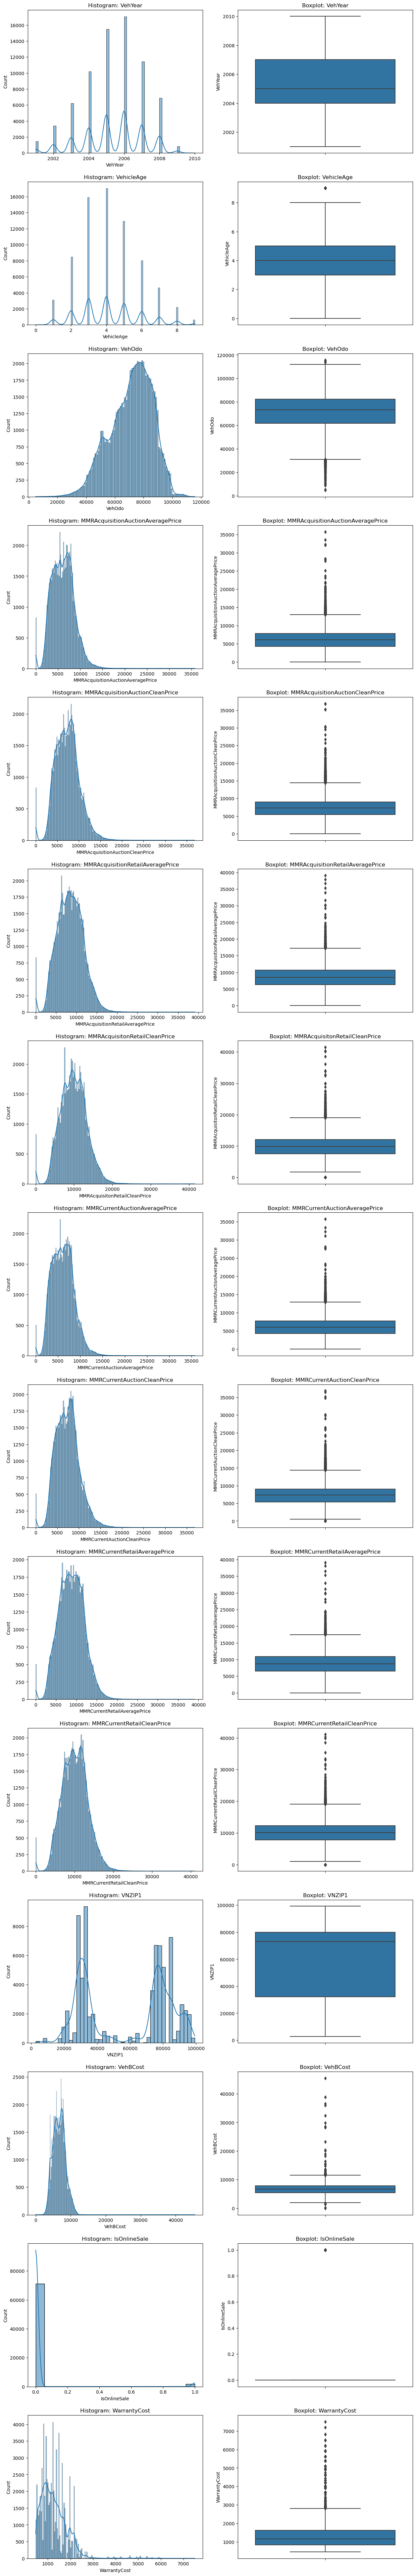

In [33]:
fig = plt.figure(figsize = (15, 100))
ax = fig.subplots(15,2)
for i, col in enumerate(num_cols):
    sns.histplot(df[col], ax=ax[i, 0], kde=True)
    ax[i, 0].set_title(f'Histogram: {col}')
    
    sns.boxplot(y=df[col], ax=ax[i, 1])
    ax[i, 1].set_title(f'Boxplot: {col}')
plt.show()

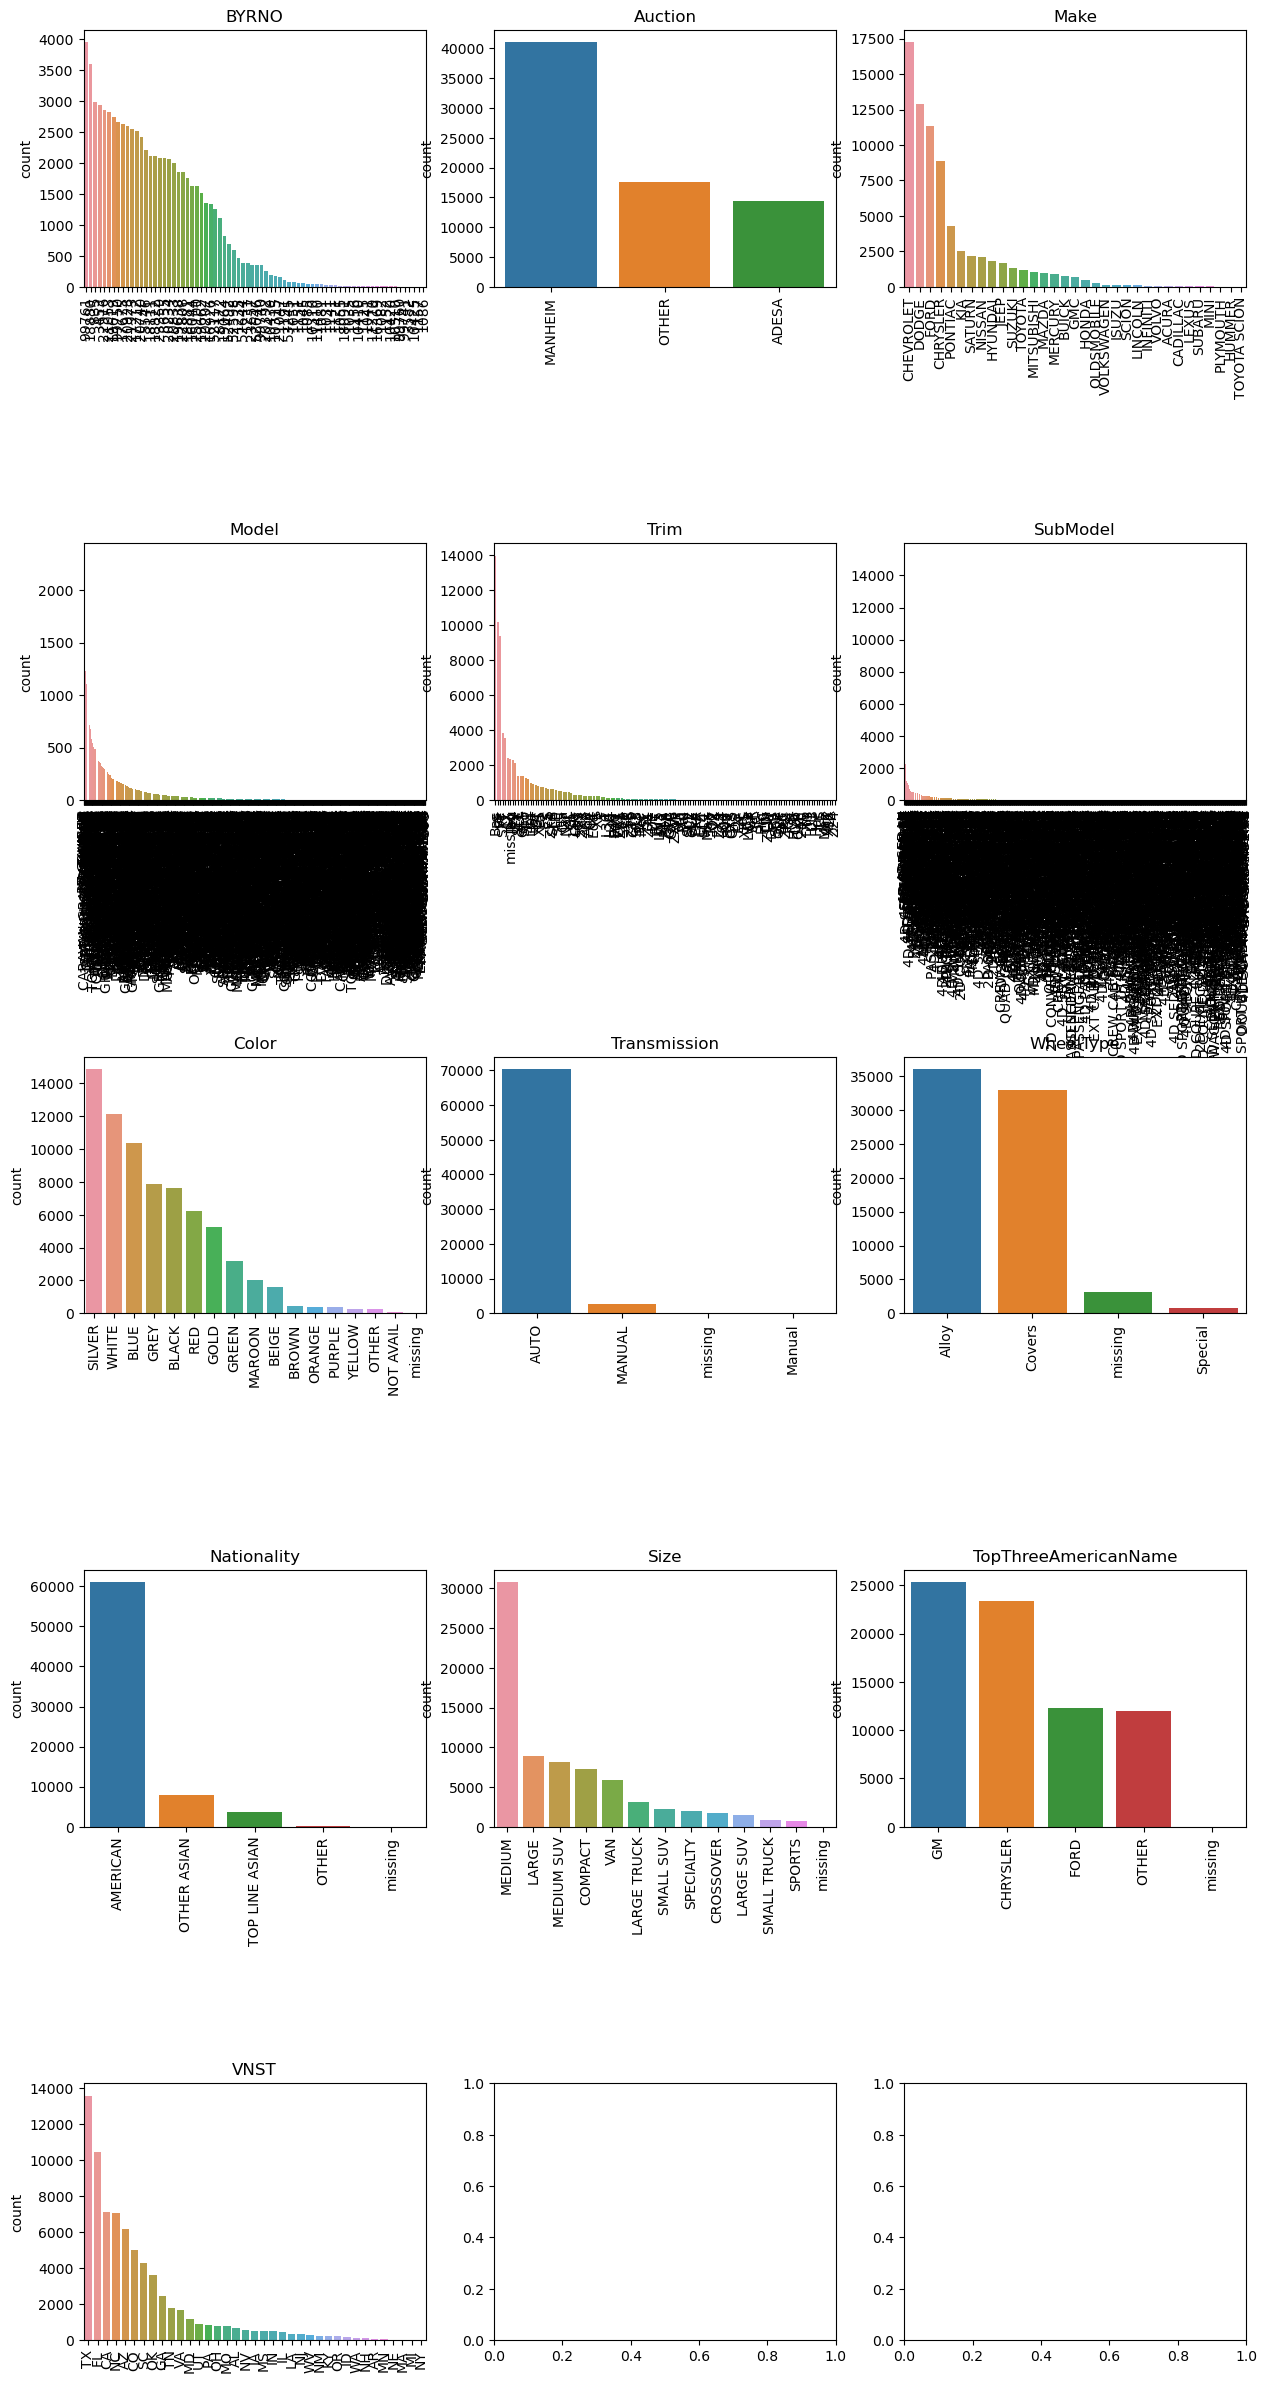

In [34]:
fig = plt.figure(figsize = (15, 30))
ax = fig.subplots(5,3).flatten()
for i, col in enumerate(ohe_cols):
    sns.countplot(x=col, data=df, ax=ax[i], order=df[col].value_counts().index)
    ax[i].set_title(col)
    ax[i].set_xlabel('')
    ax[i].tick_params(axis='x', rotation=90)
plt.subplots_adjust(hspace=1)
plt.show()

In [35]:
num_cols.remove('IsOnlineSale')
bin_cols = ['IsOnlineSale']

In [36]:
preprocessor = ColumnTransformer(transformers=[
    ('num', 'passthrough', num_cols),
    ('bin','passthrough', bin_cols),
    ('ohe', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), ohe_cols)
])

model_pipe = Pipeline(steps = [('preprocessor', preprocessor),
                               ('model', None)])

# 2-3. Create a Python class for Decision Tree Classifier and Decision Tree Regressor. With your DecisionTree module, you must obtain a Gini score of at least 0.1 on the validation dataset.

In [37]:
class Node:
    def __init__(self, depth, is_leaf=False, prediction=None, class_counts=None, n_samples=None):
        self.depth = depth
        self.is_leaf = is_leaf
        self.prediction = prediction
        self.left = None
        self.right = None
        self.feature = None
        self.value = None
        self.class_counts = class_counts
        self.n_samples = n_samples 

class MyDecisionTreeClassifier:
    def __init__(self, max_depth=10):
        self.max_depth = max_depth
        self.root = None
        
    def _gini(self, y):
        if len(y) == 0:
            return 0
        counts = np.bincount(y)
        prob = counts / len(y)
        return 1 - np.sum(prob ** 2)

    def fit(self, X, y):
        self.root = self._tree(X, y, depth=0)

    def _tree(self, X, y, depth):
        # Предсказываем по частоте классов классов
        default_prediction = Counter(y).most_common(1)[0][0] if len(y) > 0 else 0
        class_counts = np.bincount(y, minlength=2) if len(y) > 0 else np.array([0, 0])
        
        # создание листа если макс глубина
        if self.max_depth is not None and depth >= self.max_depth:
            return Node(depth, is_leaf=True, prediction=default_prediction, class_counts=class_counts)
        # создание признаков и значения для разбивки
        feature, value = self._split(X, y)
        if feature is None:
            return Node(depth, is_leaf=True, prediction=default_prediction, class_counts=class_counts)
        # построение поддеревьев
        left_index = X[:, feature] <= value
        right_index = X[:, feature] > value
        left_child = self._tree(X[left_index], y[left_index], depth + 1)
        right_child = self._tree(X[right_index], y[right_index], depth + 1)
        
        node = Node(depth)
        node.feature = feature
        node.value = value
        node.left = left_child
        node.right = right_child
        node.class_counts = class_counts
        return node
    
    def _split(self, X, y):
        X = np.array(X)
        y = np.array(y)
        n_features = X.shape[1]
        best_gini = 1.0
        best_split = None
        for feature in range(n_features):
            sorted_index = np.argsort(X[:, feature])
            sorted_features = X[sorted_index, feature]
            sorted_y = y[sorted_index]
            values = np.unique(sorted_features)
            for value in values:
                left_mask = sorted_features <= value
                n_left = np.sum(left_mask)
                if n_left == 0 or n_left == len(y):
                    continue    
                left_gini = self._gini(y[left_mask])
                right_gini = self._gini(y[~left_mask])
                gini_split = (np.sum(left_mask) * left_gini + (len(y) - n_left) * right_gini) / len(y)
            
                # обновление лучшего разбиения
                if gini_split < best_gini:
                    best_gini = gini_split
                    best_split = (feature, value)

        return best_split if best_split else (None, None)
    
    def predict_proba(self, X):
    
        def _predict_single(x):
            node = self.root
            while not node.is_leaf:
                if x[node.feature] <= node.value:
                    node = node.left
                else:
                    node = node.right

            if node.class_counts is not None and np.sum(node.class_counts) > 0:
                return node.class_counts / np.sum(node.class_counts)
            return np.array([0.5, 0.5])
    
        return np.array([_predict_single(x) for x in X])

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

In [38]:
class MyDecisionTreeRegressor:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.root = None
        
    def _mse(self, y):
        if len(y) == 0:
            return 0
        return np.mean((y - np.mean(y)) ** 2)

    def fit(self, X, y):
        self.root = self._tree(X, y, depth=0)

    def _tree(self, X, y, depth):
        # среднее значение для регрессии
        default_prediction = np.mean(y) if len(y) > 0 else 0
        n_samples = len(y) if len(y) > 0 else 0
        
        # лист если макс глубина
        if self.max_depth is not None and depth >= self.max_depth:
            return Node(depth, is_leaf=True, prediction=default_prediction, n_samples=n_samples)
        
        # признаки для разбиения
        feature, value = self._split(X, y)
        if feature is None:
            return Node(depth, is_leaf=True, prediction=default_prediction, n_samples=n_samples)
        
        # построение поддеревьев
        left_index = X[:, feature] <= value
        right_index = X[:, feature] > value
        left_child = self._tree(X[left_index], y[left_index], depth + 1)
        right_child = self._tree(X[right_index], y[right_index], depth + 1)
        
        node = Node(depth)
        node.feature = feature
        node.value = value
        node.left = left_child
        node.right = right_child
        return node
    
    def _split(self, X, y):
        X = np.array(X)
        y = np.array(y)
        n_features = X.shape[1]
        best_mse = float('inf')
        best_split = None
        for feature in range(n_features):
            sorted_index = np.argsort(X[:, feature])
            sorted_features = X[sorted_index, feature]
            sorted_y = y[sorted_index]
            values = np.unique(sorted_features)
            for value in values:
                left_mask = sorted_features <= value
                n_left = np.sum(left_mask)
                if n_left == 0 or n_left == len(y):
                    continue    
                left_mse = self._mse(y[left_mask])
                right_mse = self._mse(y[~left_mask])
                mse_split = (np.sum(left_mask) * left_mse + (len(y) - n_left) * right_mse) / len(y)
            
                # обновление лучшего разбиения
                if mse_split < best_mse:
                    best_mse = mse_split
                    best_split = (feature, value)

        return best_split if best_split else (None, None)
    
    def predict(self, X):
        def _predict_single(x):
            node = self.root
            while not node.is_leaf:
                if x[node.feature] <= node.value:
                    node = node.left
                else:
                    node = node.right
            return node.prediction
    
        return np.array([_predict_single(x) for x in X])

## Extra tree

In [39]:
class MyExtraTreeClassifier(MyDecisionTreeClassifier):
    def __init__(self, max_depth=10, n_random_splits=10, random_state=None):
        super().__init__(max_depth)
        self.n_random_splits = n_random_splits
        self.random_state = random_state
        if random_state is not None:
            np.random.seed(random_state)
    def _split(self, X, y):
        X = np.array(X)
        y = np.array(y)
        n_samples, n_features = X.shape
        if len(y) == 0 or len(np.unique(y)) == 1:
            return None, None
        
        best_gini = 1.0
        best_split = None
        # Случайный выбор
        features_to_try = np.random.choice(n_features, size=min(self.n_random_splits, n_features), replace=False)
        
        for feature in features_to_try:
            feature_values = X[:, feature]
            if len(np.unique(feature_values)) > 1:
                # Выбор случайных порогов
                min_val = np.min(feature_values)
                max_val = np.max(feature_values)
                for _ in range(self.n_random_splits):
                    value = np.random.uniform(min_val, max_val)
                    
                    left_mask = feature_values <= value
                    n_left = np.sum(left_mask)
                    if n_left == 0 or n_left == len(y):
                        continue
                    
                    left_gini = self._gini(y[left_mask])
                    right_gini = self._gini(y[~left_mask])
                    gini_split = (n_left * left_gini + (len(y) - n_left) * right_gini) / len(y)
                    if gini_split < best_gini:
                        best_gini = gini_split
                        best_split = (feature, value)
        return best_split if best_split else (None, None)

# 4. Use sklearn's DecisionTreeClassifier and check its performance on the validation dataset. Is it better than your module? If so, why?

In [40]:
def fit_models(models, model_pipe, X_train, y_train, X_valid, y_valid, report=False):
    for model_name, model in models.items():
        model_pipe.set_params(model=model)
        model_pipe.fit(X_train, y_train)
        predict_proba = model_pipe.predict_proba(X_valid)[:, 1]
        gini_score = 2* roc_auc_score(y_valid, predict_proba) -1
        print(model_name, gini_score)
        if report:
            predict = model_pipe.predict(X_valid)
            print(classification_report(y_valid, predict))
            print("\nConfusion Matrix:")
            print(confusion_matrix(y_valid, predict))

In [41]:
models = {'MyDecisionTreeClassifier': MyDecisionTreeClassifier(),
          'SkDecisionTreeClasssifier': DecisionTreeClassifier(),
          'MyExtraTreeClassifier': MyExtraTreeClassifier(random_state=21),
          'SKExtraTreeClassifier': ExtraTreeClassifier(max_depth=10, random_state=21)}

fit_models(models, model_pipe, X_train, y_train, X_valid, y_valid, report = True)

MyDecisionTreeClassifier 0.17214277492384578
              precision    recall  f1-score   support

           0       0.87      1.00      0.93     21240
           1       0.14      0.00      0.00      3174

    accuracy                           0.87     24414
   macro avg       0.50      0.50      0.47     24414
weighted avg       0.77      0.87      0.81     24414


Confusion Matrix:
[[21208    32]
 [ 3169     5]]
SkDecisionTreeClasssifier 0.1941291175831883
              precision    recall  f1-score   support

           0       0.90      0.86      0.88     21240
           1       0.26      0.34      0.29      3174

    accuracy                           0.79     24414
   macro avg       0.58      0.60      0.59     24414
weighted avg       0.81      0.79      0.80     24414


Confusion Matrix:
[[18203  3037]
 [ 2104  1070]]
MyExtraTreeClassifier 0.35761542998254425
              precision    recall  f1-score   support

           0       0.90      0.97      0.93     21240
     

DecisionTreeClassifier may have more tunable parameters and they more flexible

# 5. Implement the RandomForestClassifier and check its performance. You have to improve the result of a single tree and get at least 0.15 Gini score on the validation dataset. Be able to set a fixed random seed.

In [42]:
class MyRandomForestClassifier:
    def __init__(self, n_estimators=10, max_depth=10, max_features='sqrt', random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state
        if self.random_state is not None:
            np.random.seed(self.random_state)
        self.trees = []
        
    def _get_random_features(self, n_features):
        if self.max_features == 'sqrt':
            n_selected = int(np.sqrt(n_features))
        elif self.max_features == 'log2':
            n_selected = int(np.log2(n_features))
        else:
            n_selected = self.max_features
        
        n_selected = max(1, n_selected)
        return np.random.choice(n_features, n_selected, replace=False)
    
    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        n_samples, n_features = X.shape
        self.trees = []
        
        for i in range(self.n_estimators):
            # bootstrap
            sample_indices = np.random.choice(n_samples, n_samples, replace=True)
            X_bootstrap = X[sample_indices]
            y_bootstrap = y[sample_indices] 
            # random feature sampling 
            feature_indices = self._get_random_features(n_features)
            X_subset = X_bootstrap[:, feature_indices]
            # fit tree
            tree = MyDecisionTreeClassifier(max_depth=self.max_depth)
            tree.fit(X_subset, y_bootstrap)
            # save tree
            self.trees.append({
                'tree': tree,
                'feature_indices': feature_indices
            })
            
    def predict_proba(self, X):
        all_probas = []
        
        for tree_data in self.trees:
            tree = tree_data['tree']
            feature_indices = tree_data['feature_indices']
            X_subset = X[:, feature_indices]
            proba = tree.predict_proba(X_subset)
            all_probas.append(proba)
        
        return np.mean(all_probas, axis=0)
    
    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)

In [43]:
models = {'MyRandomForestClassifier': MyRandomForestClassifier(random_state=21),
          'SkRandomForestClasssifier': RandomForestClassifier(n_estimators=10, random_state=21)}

fit_models(models, model_pipe, X_train, y_train, X_valid, y_valid)

MyRandomForestClassifier 0.25095590407940227
SkRandomForestClasssifier 0.33108507565590006


# 6. Use your DecisionTree design class for GBDT classifier. This class must have max_depth, number_of_trees and max_features attributes. You must compute the gradient of the binary cross-entropy loss function and implement incremental learning: train the next tree using the results of the previous trees.

In [44]:
class MyGBDTClassifier:
    def __init__(self, n_estimators=100, max_depth=5, learning_rate=0.1, random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.random_state = random_state
        if self.random_state is not None:
            np.random.seed(self.random_state)
        self.trees = []
        self.initial_prediction = None
        
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -10, 10)))
    
    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        n_samples, n_features = X.shape
        self.trees = []
        
        pos_class_ratio = np.mean(y)
        self.initial_prediction = np.log(pos_class_ratio / (1 - pos_class_ratio + 1e-10))
        current_predictions = np.full(n_samples, self.initial_prediction)
        
        for i in range(self.n_estimators):
            # текущие вероятности и градиент
            current_proba = self._sigmoid(current_predictions)
            gradients = current_proba - y
            
            # random features
            n_selected = int(np.sqrt(n_features))
            feature_indices = np.random.choice(n_features, n_selected, replace=False)
            X_subset = X[:, feature_indices]
            # tree neg gradient
            tree = MyDecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X_subset, -gradients)
            tree_pred = tree.predict(X_subset)
            current_predictions += self.learning_rate * tree_pred
            self.trees.append({'tree': tree,
                               'feature_indices': feature_indices})
            
    def predict_proba(self, X):
        X = np.array(X)
        predictions = np.full(X.shape[0], self.initial_prediction)
        for tree_data in self.trees:
            tree = tree_data['tree']
            feature_indices = tree_data['feature_indices']
            X_subset = X[:, feature_indices]
            predictions += self.learning_rate * tree.predict(X_subset)
            proba_class1 = self._sigmoid(predictions)
            proba_class0 = 1 - proba_class1
            
        return np.column_stack([proba_class0, proba_class1])
    
    def predict(self, X, threshold=0.5):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)

In [45]:
models = {'MyGBDTClassifier': MyGBDTClassifier(random_state=21),
          'XGBClassifier': XGBClassifier(random_state=21)
          }
fit_models(models, model_pipe, X_train, y_train, X_valid, y_valid)

MyGBDTClassifier 0.26315762071064697
XGBClassifier 0.4467500329299854


# 7. Use LightGBM, Catboost, and XGBoost for fitting on a training set and prediction on a validation set. Review the documentation of the libraries and fine-tune the algorithms for the task.
Note key differences between each implementation. Analyze special features of each algorithm (how does "categorical feature" work in Catboost, what is DART mode in XGBoost)?
Which GBDT model gives the best result? Can you explain why?

In [46]:
models = {'XGBClassifier': XGBClassifier(random_state=21),
          'XGB_dart': XGBClassifier(booster = 'dart', random_state=21),
          'LightGBM': LGBMClassifier(verbose=0, random_state=21)
          }
print('train')
fit_models(models, model_pipe, X_train, y_train, X_train, y_train)
print('valid')
fit_models(models, model_pipe, X_train, y_train, X_valid, y_valid)
print('test')
fit_models(models, model_pipe, X_train, y_train, X_test, y_test)

train
XGBClassifier 0.9487244366622731
XGB_dart 0.9487243864047596
LightGBM 0.8217529998332957
valid
XGBClassifier 0.4467500329299854
XGB_dart 0.44674998843000524
LightGBM 0.4774362255947273
test
XGBClassifier 0.4526161374496531
XGB_dart 0.4526161374496531
LightGBM 0.4874257917014986


LightGBM fast didn't use all objects for splits, make trees deeper, work only with numeric features
CatBoost can be used with out encoders(have self encoder), work with gaps, use ordered boosting
XGBoost make morestable trees, work with gaps

# 8. Take the best model and estimate its performance on the test dataset: check the Gini values on all three datasets for your best model: training Gini, valid Gini, test Gini. Do you see a drop in performance when comparing the valid quality to the test quality? Is your model overfitting or not? Explain.

In [47]:
all_features = bin_cols + num_cols + ohe_cols
cat_pipe = Pipeline(steps = [('model', None)])

models = {'CatBoost': CatBoostClassifier(cat_features=ohe_cols,verbose = 0, random_state=21)}

print('train')
fit_models(models, cat_pipe, X_train[all_features], y_train, X_train[all_features], y_train)
print('valid')
fit_models(models,cat_pipe, X_train[all_features], y_train, X_valid[all_features], y_valid)
print('test')
fit_models(models, cat_pipe, X_train[all_features], y_train, X_test[all_features], y_test)

train
CatBoost 0.6963572533243543
valid
CatBoost 0.4763257434166728
test
CatBoost 0.4699163794265302


I choose CatBoost for good result and it simple

In [48]:
model = CatBoostClassifier(cat_features=ohe_cols, verbose= 0, random_state=21)
model.fit(X_train[all_features], y_train)
predict_proba = model.predict_proba(X_train[all_features])[:, 1]
gini_score = 2* roc_auc_score(y_train, predict_proba) -1
print('Train', gini_score)
predict_proba = model.predict_proba(X_valid[all_features])[:, 1]
gini_score = 2* roc_auc_score(y_valid, predict_proba) -1
print('Valid', gini_score)
predict_proba = model.predict_proba(X_test[all_features])[:, 1]
gini_score = 2* roc_auc_score(y_test, predict_proba) -1
print('Test', gini_score)

Train 0.6963572533243543
Valid 0.4763257434166728
Test 0.4699163794265302


Model overfited

In [49]:
param_dist_catboost = { 
    'iterations': np.logspace(2, 3.3, 10).astype(int),
    'learning_rate': np.logspace(-3, -1, 15),
    'depth': np.linspace(4, 12, 9, dtype=int),
    'l2_leaf_reg': np.logspace(0, 2, 10),
    'border_count': [32, 64, 128, 256],
    'random_strength': np.linspace(0.1, 5, 10),
    'rsm': np.linspace(0.5, 1.0, 10),
    'min_data_in_leaf': np.logspace(0, 2.7, 10).astype(int)
}
catboost = CatBoostClassifier(cat_features= ohe_cols, verbose= 0, random_seed= 21)

catboost_rand = RandomizedSearchCV(estimator=catboost, param_distributions=param_dist_catboost, scoring='roc_auc', cv=3, n_iter=25, n_jobs=-1, random_state=21)
catboost_rand.fit(X_train[all_features], y_train)


,estimator,<catboost.cor...0020EC525EF90>
,param_distributions,"{'border_count': [32, 64, ...], 'depth': array([ 4, 5..., 10, 11, 12]), 'iterations': array([ 100, ..., 1430, 1995]), 'l2_leaf_reg': array([ 1. ...100. ]), ...}"
,n_iter,25
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,21
,error_score,nan


In [50]:
best_catboost = catboost_rand.best_estimator_
predict_proba = best_catboost.predict_proba(X_train[all_features])[:, 1]
print('Gini valid', 2* roc_auc_score(y_train, predict_proba) -1)
predict_proba = best_catboost.predict_proba(X_valid[all_features])[:, 1]
print('Gini valid', 2* roc_auc_score(y_valid, predict_proba) -1)
predict_proba = best_catboost.predict_proba(X_test[all_features])[:, 1]
print('Gini test', 2* roc_auc_score(y_test, predict_proba) -1)

Gini valid 0.5957507741290469
Gini valid 0.4881882070305221
Gini test 0.5062187843007357


In [51]:
predict = model_pipe.predict(X_test[all_features])
print(classification_report(y_test, predict))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, predict))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94     21318
           1       0.84      0.22      0.35      3019

    accuracy                           0.90     24337
   macro avg       0.87      0.61      0.65     24337
weighted avg       0.89      0.90      0.87     24337


Confusion Matrix:
[[21185   133]
 [ 2341   678]]
